Compute the efficiency of an FSGP 2024 lap by querying influx for required data and computing motor energy used.

1. input lap start, end, avg. speed from timing spreadsheet
2. query influx for time series data for motor current, pack voltage, regen_enabled
3. output efficiency in J/lap and j/m

In [2]:
from data_tools import InfluxClient, TimeSeries, FSGPDayLaps
import numpy as np
import matplotlib.pyplot as plt

def calculate_lap_power(start_time: str, end_time: str) -> TimeSeries:
    client = InfluxClient()
    
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage", units="V")
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent", units="A")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")
    
    # Align x-axes
    raw_motor_current, motor_voltage, motor_current_dir = TimeSeries.align(raw_motor_current, motor_voltage, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1
    
    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

Now that we have obtained motor power, we can integrate to compute motor energy for the lap.

In [3]:
def calculate_lap_energy(start_time: str, end_time: str) -> TimeSeries:
    motor_power = calculate_lap_power(start_time, end_time)
    motor_energy = np.cumsum(motor_power) * motor_power.granularity
    motor_energy.units = "J"
    motor_energy.meta["field"] = "Motor Energy (regen adjusted)"
    return motor_energy

Now that we have the above functions., we can take compute the lap efficiency for any FSGP lap by using the FSGPDayLaps tool.

In [4]:
# Select which FSGP 2024 day to calculate lap efficiency for (1, 2 or 3)
RACE_DAY = 1  # Corresponds to July 16th
laps = FSGPDayLaps(RACE_DAY)
num_laps = laps.get_lap_count()
client = InfluxClient()

lap_energies = []
lap_speeds = np.zeros(num_laps)

for lap_idx in range(num_laps):
    lap_num = lap_idx + 1
    
    lap_start = laps.get_start_utc(lap_num)
    lap_end = laps.get_finish_utc(lap_num)
    
    lap_energies.append(  # temporarily fill with junk because I can't test with Influx right now
        np.ones(10) * np.random.mtrand.randint(low=500_000, high=750000)
    )
    # TODO: replace with below when possible
    # lap_energies.append( = calculate_lap_energy(lap_start, lap_end) <- 
    lap_speeds[lap_idx] = laps.get_lap_mph(lap_num)
    
    print(f"Total motor energy for lap {lap_num}: {lap_energies[lap_idx][-1]}J\n"
          f"Average lap speed: {lap_speeds[lap_idx]} mph\n")

lap_energies = np.array(lap_energies)
    

Total motor energy for lap 1: 614806.0J
Average lap speed: 26.745 mph

Total motor energy for lap 2: 633766.0J
Average lap speed: 31.068 mph

Total motor energy for lap 3: 631034.0J
Average lap speed: 26.372 mph

Total motor energy for lap 4: 556808.0J
Average lap speed: 26.872 mph

Total motor energy for lap 5: 639841.0J
Average lap speed: 28.492 mph

Total motor energy for lap 6: 730564.0J
Average lap speed: 29.686 mph

Total motor energy for lap 7: 697184.0J
Average lap speed: 25.541 mph

Total motor energy for lap 8: 623593.0J
Average lap speed: 29.455 mph

Total motor energy for lap 9: 568714.0J
Average lap speed: 29.152 mph

Total motor energy for lap 10: 522935.0J
Average lap speed: 29.378 mph

Total motor energy for lap 11: 714627.0J
Average lap speed: 30.484 mph

Total motor energy for lap 12: 692595.0J
Average lap speed: 25.773 mph

Total motor energy for lap 13: 582431.0J
Average lap speed: 23.924 mph

Total motor energy for lap 14: 532026.0J
Average lap speed: 23.924 mph

T

We have now obtained the lap speeds and energies for all laps on `RACE_DAY`, and we can plot the resulting data.

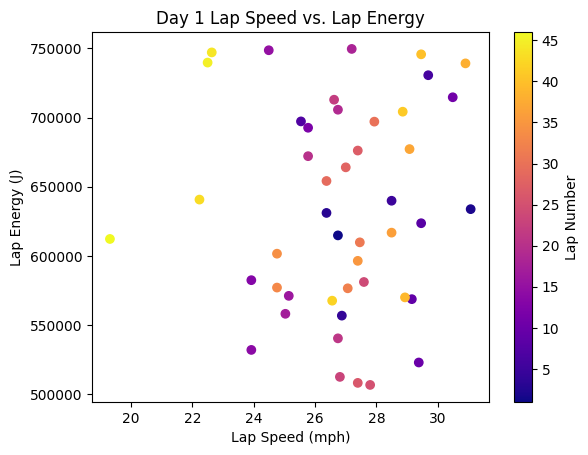

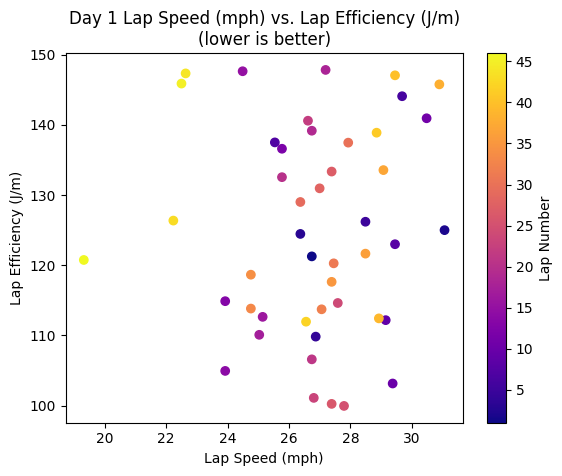

In [8]:
plt.scatter(lap_speeds, lap_energies[:, -1], c=range(1, num_laps + 1), cmap='plasma')
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Energy (J)")
plt.title(f"Day {RACE_DAY} Lap Speed vs. Lap Energy")
plt.colorbar().set_label('Lap Number')
plt.show()

FSGP_TRACK_LEN_M = 5_070
lap_efficiencies = lap_energies[:, -1] / FSGP_TRACK_LEN_M

plt.scatter(lap_speeds, lap_efficiencies, c=range(1, num_laps + 1), cmap='plasma')
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.title(f"Day {RACE_DAY} Lap Speed (mph) vs. Lap Efficiency (J/m)\n(lower is better)")
plt.colorbar().set_label('Lap Number')
plt.show()